<a href="https://colab.research.google.com/github/vagabond008/mids-266-Dipika-Jack-Ray/blob/main/W266_Final_Project_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup

In [55]:
# install packages
#!pip install -q transformers==4.37.2
!pip install -q sentencepiece
!pip install -q evaluate
!pip install -q tensorflow==2.15
!pip install -q rouge_score
!pip install utils

In [56]:
# import libraries
import os
import re
import numpy as np
import pandas as pd
import evaluate

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt

import logging
import tensorflow_hub as hub

# Set the threshold for what messages will be logged
logging.getLogger('tensorflow').setLevel(logging.ERROR)

print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers

from transformers import TFPegasusForConditionalGeneration, PegasusTokenizer

#from utils import angular_similarity, frechet_distance

from google.colab import drive
#from rouge_score import rouge_scorer



2.15.0


In [57]:
# mount Colab to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# verify data exists in Google Drive dir
#!ls 'drive/My Drive/W266'

## 2. Load Data

Load Pegasus, T5, and GPT-2 results containing Reddit posts, generated titles, and the original title (*ground truth*)

In [75]:
# set display to max width
pd.set_option('display.max_colwidth', None)

# load cleaned Reddit ds - Pegasus
df_peg = pd.read_csv('drive/My Drive/W266/pegasus_results.csv')

# load cleaned Reddit ds - T5
df_t5 = pd.read_csv('drive/My Drive/W266/t5_results.csv')

# load cleaned Reddit ds - GPT-3
df_gpt = pd.read_csv('drive/My Drive/W266/gpt_results.csv')

In [76]:
print(df_peg.info(),"\n")
print(df_t5.info(),"\n")
print(df_gpt.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Index_ID         1250 non-null   int64 
 1   ref_post         1250 non-null   object
 2   ref_title        1250 non-null   object
 3   candidate_title  1250 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.2+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Index_ID         1250 non-null   int64 
 1   ref_post         1250 non-null   object
 2   ref_title        1250 non-null   object
 3   candidate_title  1250 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.2+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 4 columns):
 #   Column           Non-

In [77]:

def subset_columns(df):
    """
    Takes a DataFrame and returns subsets containing 'ref_post', 'ref_title',
    and 'candidate_title' columns.

    Parameters:
    - df: The input DataFrame from which the subsets will be created.

    Returns:
    - A tuple of DataFrames containing the specified columns.
    """
    ref_post = pd.DataFrame(df['ref_post'])
    ref_title = pd.DataFrame(df['ref_title'])
    candidate_title = pd.DataFrame(df['candidate_title'])

    return ref_post, ref_title, candidate_title

In [97]:
# Set the number of test samples to evaluate
sample_size = 1250

### 3. Angular Similarity and Fréchet's Distance
Here we define functions for **Angular Similarity** and **Fréchet's distance**.

Angular Similarity is a measure related related to [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity). It's refers to the normalized angle between two vectors and bounded between 0 and 1. An Angular Similarity that's close to $1$ suggests that embeddings are similar in terms of semantic meaning while $0$ suggest otherwise.

[Frechet's distance](https://https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance) is a measure of similarity between two curves that takes into account the ordering and location of points. For NLP, it can be used as a quantitative measure of semanatic similarity between machined generated and human texts. Unlike Angular Similarity, lower values of Fréchet's distance indicate greater similarity.  

In [82]:

def angular_similarity(tensor_a, tensor_b):
  #normalize tensors
  norm_a = tf.nn.l2_normalize(tensor_a, axis=1)
  norm_b = tf.nn.l2_normalize(tensor_b, axis=1)

  #cosine similarity
  cosine_similarity = tf.reduce_sum(tf.multiply(norm_a, norm_b), axis=1)

  #angular similarity
  angular_similarity = (1 - tf.acos(cosine_similarity) / np.pi).numpy()

  return angular_similarity

def frechet_distance(tensor_a, tensor_b):
  #euclidean distance
  frechet_distance = tf.norm(tensor_a - tensor_b, ord='euclidean').numpy()

  #print("Fréchet Distance :", frechet_distance)

  return frechet_distance

In [83]:
# Test the Angular Similarity and Frechet's Distance
tensor_a = tf.constant([[1, 1]], dtype=tf.float32)
tensor_b = tf.constant([[1, 1]], dtype=tf.float32)
print("Angular Sim :",angular_similarity(tensor_a, tensor_b))
print("Frechet :",frechet_distance(tensor_a, tensor_b))

Angular Sim : [0.9998901]
Frechet : 0.0


## 4. Universal Sentence Encoder

In [84]:
# Import the Universal Sentence Encoder's TF Hub module

# Assume module_url is defined somewhere in your code
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(module_url)

## 5. Model Evaluation: Angular Embedding Similarity and Fréchet's Distance

### Pegasus

In [85]:
# Encode Pegasus with USE
ref_post, ref_title, candidate_title = subset_columns(df_peg)

# Embed data
# original post
ref_post_embeddings = embed(ref_post[:sample_size].values.flatten())

# original title (ground truth)
ref_title_embeddings = embed(ref_title[:sample_size].values.flatten())

# generated title
candidate_title_embeddings = embed(candidate_title[:sample_size].values.flatten())

# print first 5 records
candidate_title.head(5)

,candidate_title
0,what are some good data science bootcamps
1,is there a better way to store and train a model for later use
2,how to deal with missing values in logistic regression
3,how do i go about retraining my google analytics model
4,how do i deal with missing values in logistic regression


In [86]:
# Angular Similarity Calculation
ang_sim_gen_title_ref_post = []
ang_sim_ref_title_ref_post = []

# Fréchet's Distance Calculation
fd_gen_title_ref_post = []
fd_ref_title_ref_post = []

for i in range(len(candidate_title_embeddings)):

  gen_title = np.expand_dims(candidate_title_embeddings[i], axis=0)
  ref_title = np.expand_dims(ref_title_embeddings[i], axis=0)
  ref_post = np.expand_dims(ref_post_embeddings[i], axis=0)

  # compare Angular Sim - generated title vs original post
  ang_sim_gen_title_ref_post.append(float(angular_similarity(gen_title, ref_post)[0]))

  # compare Angular Sim - original title (ground truth) vs original post
  ang_sim_ref_title_ref_post.append(float(angular_similarity(ref_title, ref_post)[0]))

  # compare Fréchet's Distance - generated title vs original post
  fd_gen_title_ref_post.append(float(frechet_distance(gen_title, ref_post)))

  # compare Fréchet's Distance -  original title (ground truth) vs original post
  fd_ref_title_ref_post.append(float(frechet_distance(ref_title, ref_post)))

print(" Pegasus Results ".center(50, "*"))
print("Shape :",candidate_title_embeddings.shape)

# Angular Similarity
summary_ang_sim_gen_title_ref_post = np.mean(ang_sim_gen_title_ref_post)
print("Angular Sim - Candidate Title vs Ref Post :\t\t",summary_ang_sim_gen_title_ref_post)
summary_ang_sim_ref_title_ref_post = np.mean(ang_sim_ref_title_ref_post)
print("Angular Sim - Ref Title vs Ref Post :\t\t\t",summary_ang_sim_ref_title_ref_post,"\n")

# Fréchet's Distance
summary_fd_gen_title_ref_post = np.mean(fd_gen_title_ref_post)
print("Fréchet's Distance - Candidate Title vs Ref Post :\t",summary_fd_gen_title_ref_post)

summary_fd_ref_title_ref_post = np.mean(fd_ref_title_ref_post)
print("Fréchet's Distance - Ref Title vs Ref Post :\t\t",summary_fd_ref_title_ref_post)

**************** Pegasus Results *****************
Shape : (1250, 512)
Angular Sim - Candidate Title vs Ref Post :		 0.6372447463512421
Angular Sim - Ref Title vs Ref Post :			 0.640458917093277 

Fréchet's Distance - Candidate Title vs Ref Post :	 1.0755447518825532
Fréchet's Distance - Ref Title vs Ref Post :		 1.0669682736873627


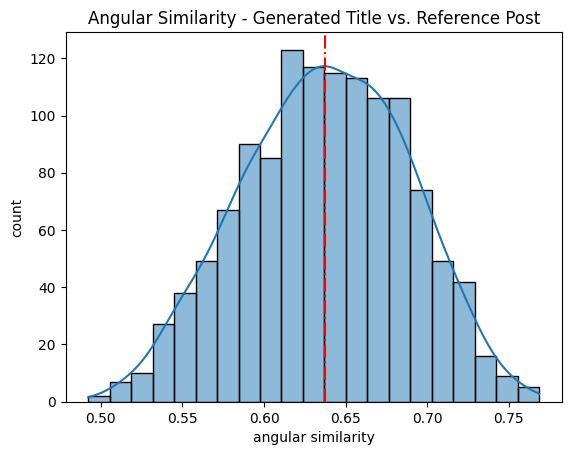

In [87]:
# Angular Similarity - Generated Title vs. Reference Post
sns.histplot(ang_sim_gen_title_ref_post, kde=True)
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Angular Similarity - Generated Title vs. Reference Post')
plt.axvline(summary_ang_sim_gen_title_ref_post,linestyle='-.', color='red')

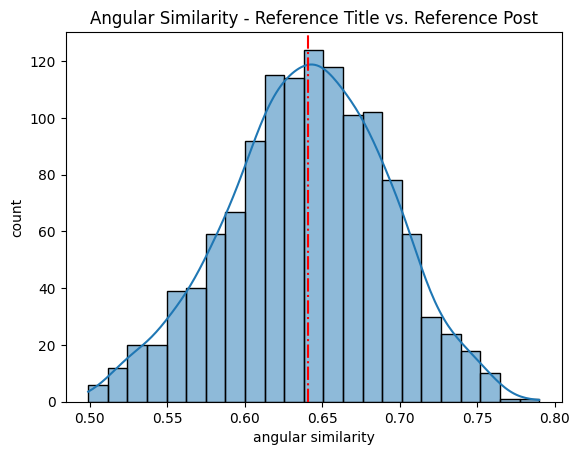

In [88]:
# Angular Similarity - Reference Title vs. Reference Post
sns.histplot(ang_sim_ref_title_ref_post, kde=True)
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Angular Similarity - Reference Title vs. Reference Post')
plt.axvline(summary_ang_sim_ref_title_ref_post,linestyle='-.',color='red')

### T5

In [89]:
# Encode T5
ref_post, ref_title, candidate_title = subset_columns(df_t5)

# Embed data
# original post
ref_post_embeddings = embed(ref_post[:sample_size].values.flatten())

# original title (ground truth)
ref_title_embeddings = embed(ref_title[:sample_size].values.flatten())

# generated title
candidate_title_embeddings = embed(candidate_title[:sample_size].values.flatten())

# print first 5 records
candidate_title.head(5)

,candidate_title
0,what is the best way to get a job in the field of data science
1,python spacy for ngrams
2,what is the best way of calculating the weights for a neural network
3,what is the best way of storing a large amount of data in the retraining process
4,how do i get the best results out of the mahalanobis dataset


In [90]:
# Angular Similarity Calculation
ang_sim_gen_title_ref_post = []
ang_sim_ref_title_ref_post = []

# Fréchet's Distance Calculation
fd_gen_title_ref_post = []
fd_ref_title_ref_post = []

for i in range(len(candidate_title_embeddings)):

  gen_title = np.expand_dims(candidate_title_embeddings[i], axis=0)
  ref_title = np.expand_dims(ref_title_embeddings[i], axis=0)
  ref_post = np.expand_dims(ref_post_embeddings[i], axis=0)

  # compare Angular Sim - generated title vs original post
  ang_sim_gen_title_ref_post.append(float(angular_similarity(gen_title, ref_post)[0]))

  # compare Angular Sim - original title (ground truth) vs original post
  ang_sim_ref_title_ref_post.append(float(angular_similarity(ref_title, ref_post)[0]))

  # compare Fréchet's Distance - generated title vs original post
  fd_gen_title_ref_post.append(float(frechet_distance(gen_title, ref_post)))

  # compare Fréchet's Distance -  original title (ground truth) vs original post
  fd_ref_title_ref_post.append(float(frechet_distance(ref_title, ref_post)))

print(" T5 Results ".center(50, "*"))
print("Shape :",candidate_title_embeddings.shape)

# Angular Similarity
summary_ang_sim_gen_title_ref_post = np.mean(ang_sim_gen_title_ref_post)
print("Angular Sim - Candidate Title vs Ref Post :\t\t",summary_ang_sim_gen_title_ref_post)
summary_ang_sim_ref_title_ref_post = np.mean(ang_sim_ref_title_ref_post)
print("Angular Sim - Ref Title vs Ref Post :\t\t\t",summary_ang_sim_ref_title_ref_post,"\n")

# Fréchet's Distance
summary_fd_gen_title_ref_post = np.mean(fd_gen_title_ref_post)
print("Fréchet's Distance - Candidate Title vs Ref Post :\t",summary_fd_gen_title_ref_post)

summary_fd_ref_title_ref_post = np.mean(fd_ref_title_ref_post)
print("Fréchet's Distance - Ref Title vs Ref Post :\t\t",summary_fd_ref_title_ref_post)

******************* T5 Results *******************
Shape : (1250, 512)
Angular Sim - Candidate Title vs Ref Post :		 0.6484775321960449
Angular Sim - Ref Title vs Ref Post :			 0.640458917093277 

Fréchet's Distance - Candidate Title vs Ref Post :	 1.046222029018402
Fréchet's Distance - Ref Title vs Ref Post :		 1.0669682736873627


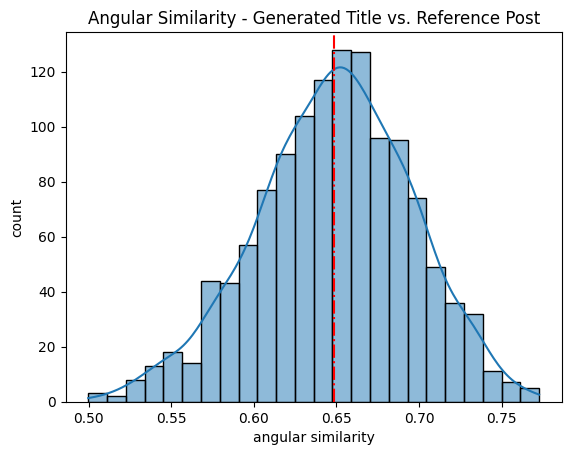

In [91]:
# Angular Similarity - Generated Title vs. Reference Post
sns.histplot(ang_sim_gen_title_ref_post, kde=True)
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Angular Similarity - Generated Title vs. Reference Post')
plt.axvline(summary_ang_sim_gen_title_ref_post,linestyle='-.', color='red')

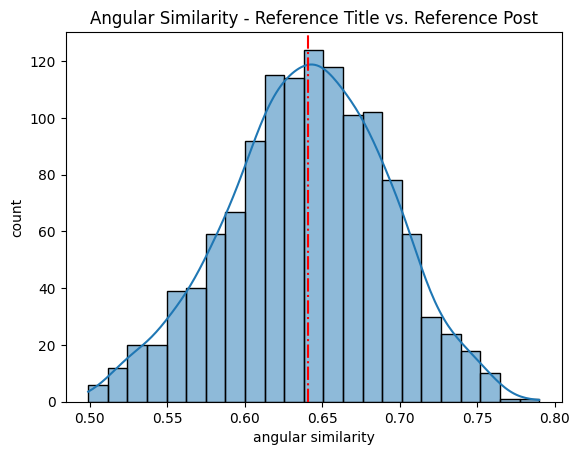

In [92]:
# Angular Similarity - Reference Title vs. Reference Post
sns.histplot(ang_sim_ref_title_ref_post, kde=True)
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Angular Similarity - Reference Title vs. Reference Post')
plt.axvline(summary_ang_sim_ref_title_ref_post,linestyle='-.',color='red')

### GPT-2

In [93]:
# Encode Pegasus with USE
ref_post, ref_title, candidate_title = subset_columns(df_gpt)

# Embed data
# original post
ref_post_embeddings = embed(ref_post[:sample_size].values.flatten())

# original title (ground truth)
ref_title_embeddings = embed(ref_title[:sample_size].values.flatten())

# generated title
candidate_title_embeddings = embed(candidate_title[:sample_size].values.flatten())

# print first 5 records
candidate_title.head(5)

,candidate_title
0,some background i have been learning python for over a year now and i know some sql a bit of r and i have completed some small projects using data science data engineering practices i also know how to work in excel but i do not really have experience using databases i am totally willing to make the time and money investment in something like a bootcamp and i have the means to do fulltime training but i do not want to do this if there is a better faster way to get into the industry what i really want to know is what can i do that will get me a job in the field asap is there some specific bootcamp that will make this happen if so what are the best bootcamps or some particular tech skill i could learn that would basically guarantee that i am hireable very soon if i something like learned microsoft sql server or tableau and given my other skills would this be likely to get me hired i have been looking into bootcamps like thinkful springboard and data application lab the concern i have about these is actually that i already know a lot of the stuff they teach and i am worried that these will be a waste of time and not elevate me to where i want to be i also worry about it taking months to complete these programs as they estimate i would like to be finished in no more than about months thoughts
1,hi all i have created a python module to extract sngrams which is different from traditional ngrams as it embodies linguistic syntactic trees thus making it less arbitrary than traditional ngrams as it goes without saying quality of input feature affects model performance this will help you improve your model accuracy even further built on language models of spacy it can help especially for text classification information extraction query understanding machine translation question answering systems below is an example from sngramextractor import sngramextractor ampxb sngram_objsngramextractortextmeta_tagoriginaltrigram_flagyes texteconomic news have little effect on financial markets outputsngram_objget_sngram printtext print isngram bigramoutput isnbigram print isngram trigramoutput isntrigram economic news have little effect on financial markets sngram bigram cloud_every has_cloud lining_a lining_silver has_lining sngram trigram has_lining_silver ampxb textevery cloud has a silver lining outputsngram_objget_sngram printtext print isngram bigramoutput isnbigram print isngram trigramoutput isntrigram ampxb every cloud has a silver lining sngram bigram cloud_every has_cloud lining_a lining_silver has_lining sngram trigram has_lining_silver ampxb pypi
2,i am looking at some of the modeling programs the company has been using and there are options to smooth binned data layered linear on bin linear on avg linear on log avg and variable gradient are these methods commonly used in any algorithms i am not sure how i would implement it into r ampxb variable gradient is the most confusing it groups data from neighboring bins with a bin factor being determined the level of smoothing is determined by the radius all bins contribute to the calculation of the bin factor with decreasing weight as the distance from the target bin increases the weight is equal to radius distance radius ampxb once you calculate the overall factor a calculation is performed for each bin weighted by an exposure with various radii and a selected credibility level the calculation that yields the largest distance from is then selected as the factor to be used for that bin ampxb over multiple iterations of the model the factors are blended until the model converges and we receive a final coefficient for that bin ampxb since it is a program i have no clue what is going on in the background to calculate the convergence or what type of model this is it ends up being a multiplicative model so i am guessing it is a log linked glm
3,let is say i have created a fraud detection model i already have a process that cleans the data and stores the trainable data in a table i

In [94]:
# Angular Similarity Calculation
ang_sim_gen_title_ref_post = []
ang_sim_ref_title_ref_post = []

# Fréchet's Distance Calculation
fd_gen_title_ref_post = []
fd_ref_title_ref_post = []

for i in range(len(candidate_title_embeddings)):

  gen_title = np.expand_dims(candidate_title_embeddings[i], axis=0)
  ref_title = np.expand_dims(ref_title_embeddings[i], axis=0)
  ref_post = np.expand_dims(ref_post_embeddings[i], axis=0)

  # compare Angular Sim - generated title vs original post
  ang_sim_gen_title_ref_post.append(float(angular_similarity(gen_title, ref_post)[0]))

  # compare Angular Sim - original title (ground truth) vs original post
  ang_sim_ref_title_ref_post.append(float(angular_similarity(ref_title, ref_post)[0]))

  # compare Fréchet's Distance - generated title vs original post
  fd_gen_title_ref_post.append(float(frechet_distance(gen_title, ref_post)))

  # compare Fréchet's Distance -  original title (ground truth) vs original post
  fd_ref_title_ref_post.append(float(frechet_distance(ref_title, ref_post)))

print(" GPT Results ".center(50, "*"))
print("Shape :",candidate_title_embeddings.shape)

# Angular Similarity
summary_ang_sim_gen_title_ref_post = np.mean(ang_sim_gen_title_ref_post)
print("Angular Sim - Candidate Title vs Ref Post :\t\t",summary_ang_sim_gen_title_ref_post)
summary_ang_sim_ref_title_ref_post = np.mean(ang_sim_ref_title_ref_post)
print("Angular Sim - Ref Title vs Ref Post :\t\t\t",summary_ang_sim_ref_title_ref_post,"\n")

# Fréchet's Distance
summary_fd_gen_title_ref_post = np.mean(fd_gen_title_ref_post)
print("Fréchet's Distance - Candidate Title vs Ref Post :\t",summary_fd_gen_title_ref_post)

summary_fd_ref_title_ref_post = np.mean(fd_ref_title_ref_post)
print("Fréchet's Distance - Ref Title vs Ref Post :\t\t",summary_fd_ref_title_ref_post)

****************** GPT Results *******************
Shape : (1250, 512)
Angular Sim - Candidate Title vs Ref Post :		 nan
Angular Sim - Ref Title vs Ref Post :			 0.640458917093277 

Fréchet's Distance - Candidate Title vs Ref Post :	 0.011734050008654594
Fréchet's Distance - Ref Title vs Ref Post :		 1.0669682736873627


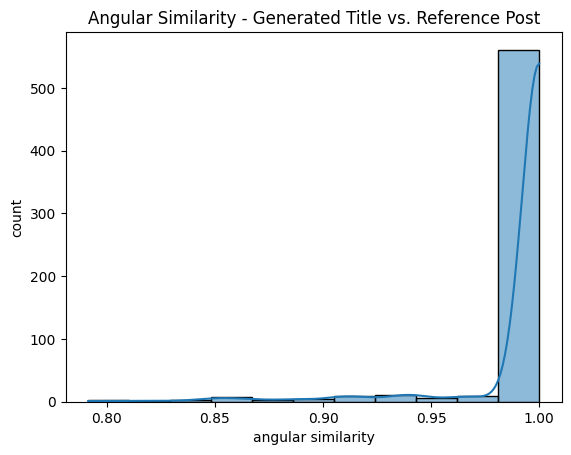

In [95]:
# Angular Similarity - Generated Title vs. Reference Post
sns.histplot(ang_sim_gen_title_ref_post, kde=True)
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Angular Similarity - Generated Title vs. Reference Post')
plt.axvline(summary_ang_sim_gen_title_ref_post,linestyle='-.', color='red')

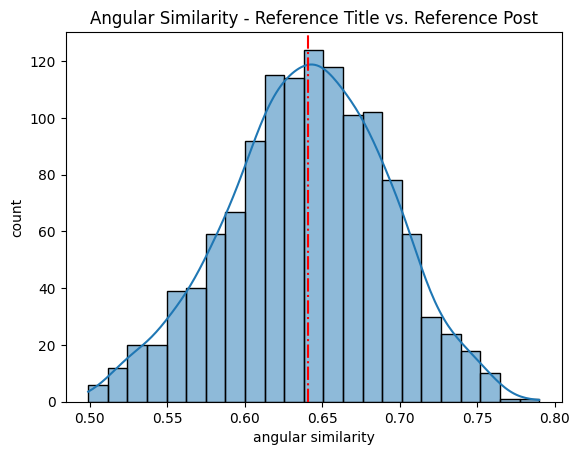

In [96]:
# Angular Similarity - Reference Title vs. Reference Post
sns.histplot(ang_sim_ref_title_ref_post, kde=True)
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Angular Similarity - Reference Title vs. Reference Post')
plt.axvline(summary_ang_sim_ref_title_ref_post,linestyle='-.',color='red')